# Large-scale structures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import Planck18
from scipy.integrate import quad
from scipy.optimize import brentq

## Scales

In [50]:
sizes = {'human': 2*u.m,
         'planet': 1e4 * u.km  ,
          'star': 1e7 * u.km,
          'dwarf galaxy': 1e3 * u.pc,  # SMC
          'galaxy': 1e4 * u.pc,
           'cluster': 1 * u.Mpc,
           'supercluster': 50 * u.Mpc}

for key in sizes.keys():
    print(key, sizes[key].to(u.Mpc))

human 6.48155857888873e-23 Mpc
planet 3.2407792894443647e-16 Mpc
star 3.240779289444365e-13 Mpc
dwarf galaxy 0.001 Mpc
galaxy 0.01 Mpc
cluster 1.0 Mpc
supercluster 50.0 Mpc


In [98]:
Omegam0 = 0.3
Omegar0 = 5e-5
Omegab0 = 5e-2
T0 = 2.73 * u.K
a0 = 1
adec = 1./1100
aeq = 1./3330
H0 = 70 * u.km / u.s / u.Mpc
rhoc0 = (3 * Planck18.H0**2 / (8 * np.pi * const.G)).to(u.kg/u.m**3)

In [62]:
rhoc0, rhoc0 / const.m_p

(<Quantity 8.59881426e-27 kg / m3>, <Quantity 5.14091926 1 / m3>)

### Density contrast $\delta$

In [63]:
masses = {'human': 1e2*u.kg,
          'planet': 1e-3 * u.Msun  ,
          'star': 1 * u.Msun,
          'dwarf galaxy': 1e10 * u.Msun,  # SMC
          'galaxy': 1e12 * u.Msun,
           'cluster': 1e14 * u.Msun,
           'supercluster': 1e17 * u.Msun}

for key in sizes.keys():
    print(key, "delta ~", ((masses[key] / sizes[key]**3)/rhoc0).to(u.dimensionless_unscaled))

human delta ~ 1.4536888025430215e+27
planet delta ~ 2.3124233311198196e+32
star delta ~ 2.3124233311198192e+26
dwarf galaxy delta ~ 78707425.48060761
galaxy delta ~ 7870742.548060761
cluster delta ~ 787.0742548060762
supercluster delta ~ 6.2965940384486085


## Jeans scales

In [108]:
def rhotot(a):
    return rhoc0 * (Omegam0*(a0/a)**3 + Omegar0*(a0/a)**4)

def cs(a):
    if a < adec:
        return (const.c / np.sqrt(3) * 1/np.sqrt(1+3*a/4*Omegab0/Planck18.Ogamma0)).to(u.m / u.s)
    else:
        Tdec = T0 * (a0 / a)  # get T_baryons at decoupling
        T = Tdec * (adec / a)**2  # check that baryon temperature decrease in 1/a^2
        return np.sqrt(5 * const.k_B * T / (3*1.72*const.m_p )).to(u.m / u.s)

def LJ(a):
    return np.sqrt(np.pi/(const.G * rhotot(a))) * cs(a)

def MJ(a):
    return (4/3*np.pi*LJ(a)**3 *rhotot(a) / const.M_sun).to(u.dimensionless_unscaled)

MJ(1e-4), MJ(adec), cs(1), cs(adec), cs(adec)/const.c

(<Quantity 1.21616726e+18>,
 <Quantity 1256371.66527083>,
 <Quantity 0.13433573 m / s>,
 <Quantity 4900.9533234 m / s>,
 <Quantity 1.63478206e-05>)

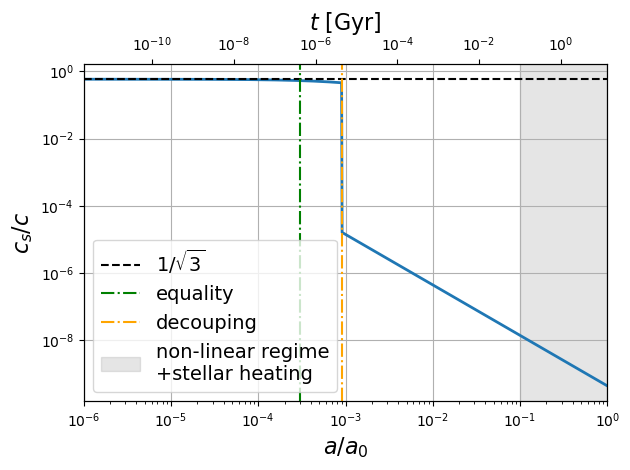

In [150]:
#| label: LSS_cs

aa = np.logspace(-6, -1e-6, 1000)
zz = 1/aa-1

fig = plt.figure()
plt.plot(aa, [cs(a)/const.c for a in aa], '-', lw=2)
#plt.gca().invert_xaxis()
#plt.axhline(1e12, label="galaxy mass", color="r", linestyle="--")
plt.axhline(1/np.sqrt(3), label="$1/\sqrt{3}$", color="k", linestyle="--")
plt.axvline(aeq, label="equality", color="g", linestyle="-.")
plt.axvline(adec, label="decouping", color="orange", linestyle="-.")
plt.axvspan(0.1, 1, alpha=0.2, color="gray", label="non-linear regime\n+stellar heating")  #horizontal shading
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$a/a_0$", fontsize=16)
plt.ylabel("$c_s/c$", fontsize=16)
plt.xlim(np.min(aa), 1)
plt.grid()
plt.legend(fontsize=14)

secax = plt.gca().twiny()
ttt = Planck18.age(zz)
secax.plot(ttt, 0.1*np.ones_like(ttt), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [Gyr]', fontsize=16)
secax.set_xlim(np.min(ttt.value), np.max(ttt.value))

fig.tight_layout()
plt.show()

In [154]:
Planck18.age(1e8).to(u.s)
#Planck18.lookback_time(1000)

<Quantity 0.06660535 s>

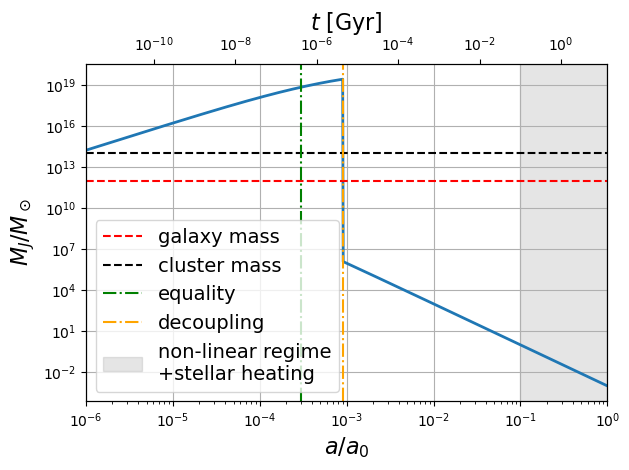

In [159]:
#| label: LSS_MJ

aa = np.logspace(-6, -1e-6, 1000)
zz = 1/aa-1

fig = plt.figure()
plt.plot(aa, [MJ(a) for a in aa], '-', lw=2)
# plt.axhline(5e9, label="dwarf galaxy mass", color="b", linestyle="--")  # SMC
# plt.axhline(masses["dwarf galaxy"]/u.Msun, label="galaxy mass", color="r", linestyle="--")
plt.axhline(masses["galaxy"]/u.Msun, label="galaxy mass", color="r", linestyle="--")
plt.axhline(masses["cluster"]/u.Msun, label="cluster mass", color="k", linestyle="--")
plt.axvline(aeq, label="equality", color="g", linestyle="-.")
plt.axvline(adec, label="decoupling", color="orange", linestyle="-.")
plt.axvspan(0.1, 1, alpha=0.2, color="gray", label="non-linear regime\n+stellar heating")  #horizontal shading
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$a/a_0$", fontsize=16)
plt.ylabel("$M_J/M_\odot$", fontsize=16)
plt.xlim(np.min(aa), 1)
plt.grid()
plt.legend(fontsize=14, loc="lower left")


secax = plt.gca().twiny()
ttt = Planck18.age(zz)
secax.plot(ttt, 0.1*np.ones_like(ttt), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [Gyr]', fontsize=16)
secax.set_xlim(np.min(ttt.value), np.max(ttt.value))

fig.tight_layout()
plt.show()

In [75]:
integrand = lambda a: (Planck18.H0*cs(a)/const.c/(a**2*Planck18.H(1/a-1))) #.to(u.dimensionless_unscaled)

rs_comobile = (quad(integrand, 1e-8, adec-1e-12)[0])*(const.c/Planck18.H0).to(u.Mpc)
rs_proper = rs_comobile * adec
rs_proper, rs_comobile
# rs/Planck18.angular_diameter_distance(1/adec)

(<Quantity 0.13043338 Mpc>, <Quantity 143.4767135 Mpc>)

In [ ]:
Planck18.

## $\sigma_8$

In [9]:
Ngal_8 = np.array([5, 19, 31, 8, 17, 11, 13, 19, 17, 22, 2, 18, 8, 12, 10, 16, 18, 13, 4, 21, 14, 10, 7, 23, 4, 6, 11, 9, 10, 10, 12, 5, 5, 14, 11, 10, 23, 22, 11, 5, 12, 6, 11, 11, 9, 11, 23, 1, 5, 7, 7, 10, 22, 19, 5, 22, 10, 4, 10, 9, 27, 4, 5, 7, 5, 7, 15, 12, 10, 13, 21, 22, 18])
Ngal_8_mean = np.mean(Ngal_8)
Ngal_8_std = np.std(Ngal_8)
print(f'{Ngal_8.size=} {Ngal_8_mean=}\t\t{Ngal_8_std=}')

Ngal_8.size=73 Ngal_8_mean=12.136986301369863		Ngal_8_std=6.536127353458947


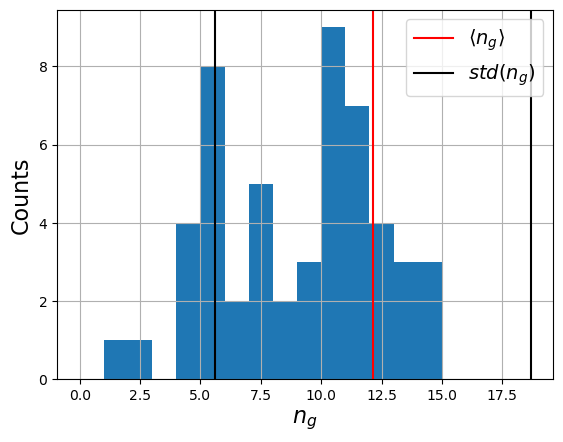

In [10]:
fig = plt.figure()
plt.hist(Ngal_8, bins=np.arange(0,16,1))
plt.axvline(Ngal_8_mean, color="r", label=r"$\left\langle n_g\right\rangle$")
plt.axvline(Ngal_8_mean+Ngal_8_std, color='k', label=r"$std(n_g)$")
plt.axvline(Ngal_8_mean-Ngal_8_std, color='k')
plt.ylabel("Counts", fontsize=16)
plt.xlabel("$n_g$", fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [11]:
deltag = (Ngal_8 - Ngal_8_mean)/Ngal_8_mean
bs8 = np.std(deltag)
print(f'bs8 = {bs8:.3f}')
print('BOSS measurement at z=1.2: 0.661 +/- 0.331')

bs8 = 0.539
BOSS measurement at z=1.2: 0.661 +/- 0.331


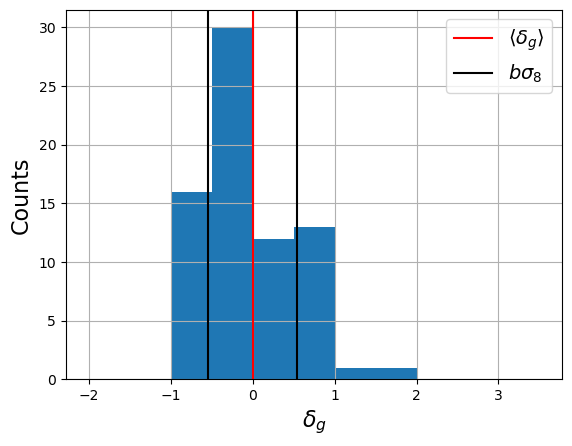

In [12]:
fig = plt.figure()
plt.axvline(0, color="r", label=r"$\left\langle \delta_g\right\rangle$")
plt.hist(deltag, bins=np.arange(-2,4,0.5))
plt.axvline(bs8, color='k', label="$b\sigma_8$")
plt.axvline(-bs8, color='k')
plt.ylabel("Counts", fontsize=16)
plt.xlabel("$\delta_g$", fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.show()

## Power spectrum

In [13]:
import pyccl as ccl

In [14]:
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05,
                          h=0.7, n_s=0.95, sigma8=0.8,
                          transfer_function='eisenstein_hu')

In [15]:
kmin, kmax, nk = 1e-4, 1e1, 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a = 1. # Scale factor a z=0

In [16]:
pk_lin = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)

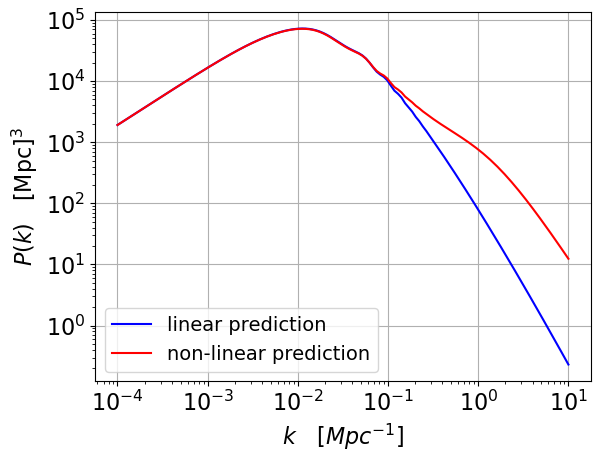

In [17]:
fig = plt.figure()
plt.plot(k, pk_lin, 'b-', label="linear prediction")
plt.plot(k, pk_nl, 'r-', label="non-linear prediction")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 16)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

## Galaxy bias

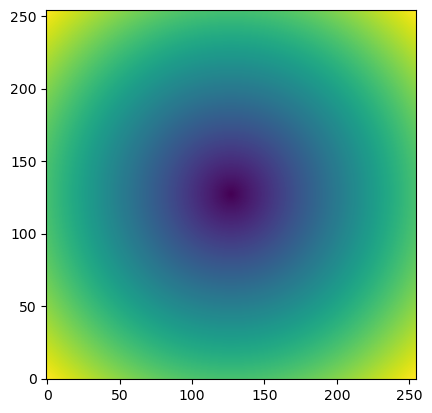

In [18]:
N = 255
DeltaX = 1
kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(N, d=DeltaX))
ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(N, d=DeltaX))
kky, kkx = np.meshgrid(kx, ky)

k = np.sqrt(kkx*kkx + kky*kky)

plt.imshow(k, origin="lower")
plt.show()

In [19]:
np.unique(k)

array([0.        , 0.02463994, 0.03484614, ..., 4.390752  , 4.40807123,
       4.42545987])

In [20]:
def antisymetrize(phase):
    N = phase.shape[0]
    if phase.shape[0] % 2 == 0 or phase.shape[1] % 2 == 0:
        print("ATTENTION ! La taille du tableau doit etre impaire.")
    phase[:, :N//2] = -phase[::-1, :N//2:-1]
    phase[:N//2:, N//2] = -phase[:N//2:-1, N//2]
    phase[N//2, N//2] = 0
    if not np.isclose(np.sum(phase), 0):
        print(f"La somme du tableau n'est pas nulle mais vaut {np.sum(phase)}.  Un probleme ?")
    return phase

In [21]:
# beta = 3
# amp = k**(-beta/2)

amp = np.zeros_like(k)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        # multiply by 10 to increase arbitrarily fluctuations
        amp[i,j] = 10*np.sqrt(ccl.linear_matter_power(cosmo, k[i,j], a))

amp[ np.isinf(amp) ] = 0

def make_gaussian_filed(amp):
    phase = np.random.uniform(-np.pi, np.pi, size=k.shape)
    phase = antisymetrize(phase)

    deltam_fourier = amp * np.exp(1j * phase)
    deltam = np.fft.ifft2(np.fft.ifftshift(deltam_fourier)).real

    # Log-normalisation of the distribution
    deltam = np.exp(deltam)#/np.std(deltam)
    # deltam += -np.mean(deltam) + 1   # mean for delta rho to be 1
    return deltam

deltam = make_gaussian_filed(amp)

ns = 1
deltaini = make_gaussian_filed(k**(ns/2))

/Users/jneveu/miniforge3/envs/m2-cosmo/lib/python3.11/site-packages/pyccl/pk2d.py:287: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)


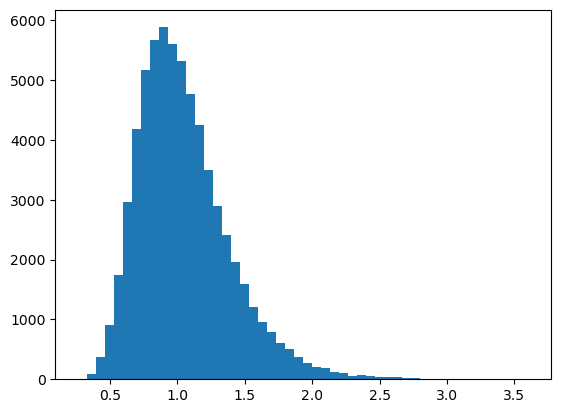

In [22]:
fig = plt.figure()
plt.hist(deltam.ravel(), bins=50)
plt.show()

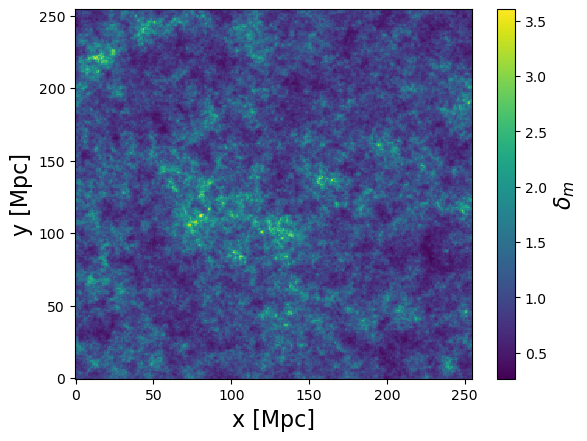

In [23]:
fig = plt.figure()
plt.pcolor(np.arange(0, N)*DeltaX, np.arange(0, N)*DeltaX, deltam)
cb = plt.colorbar()
cb.set_label(label="$\delta_m$", fontsize=16)
plt.xlabel("x [Mpc]", fontsize=16)
plt.ylabel("y [Mpc]", fontsize=16)
plt.show()

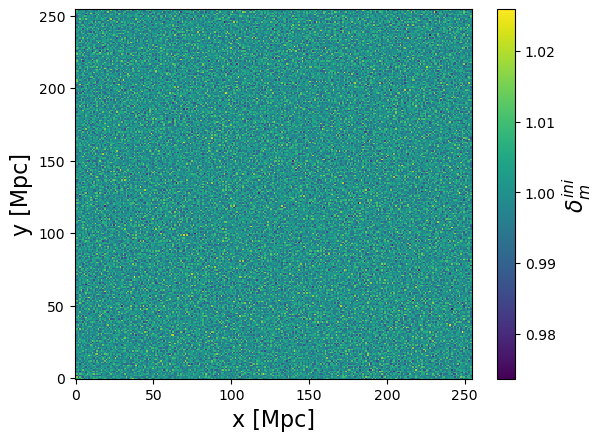

In [24]:
fig = plt.figure()
plt.pcolor(np.arange(0, N)*DeltaX, np.arange(0, N)*DeltaX, deltaini)
cb = plt.colorbar()
cb.set_label(label="$\delta_m^{ini}$", fontsize=16)
plt.xlabel("x [Mpc]", fontsize=16)
plt.ylabel("y [Mpc]", fontsize=16)
plt.show()

Sampling with a galaxy population with a bias $b$

In [25]:
bias = 4

deltag = np.random.poisson(bias * deltam)

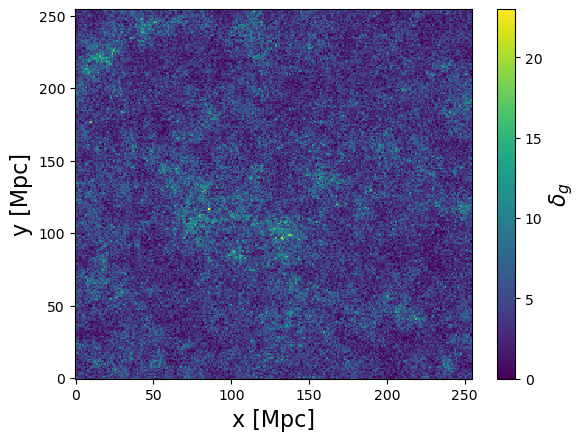

In [26]:
fig = plt.figure()
plt.pcolor(np.arange(0, N)*DeltaX, np.arange(0, N)*DeltaX, deltag)
cb = plt.colorbar()
cb.set_label(label="$\delta_g$", fontsize=16)
plt.xlabel("x [Mpc]", fontsize=16)
plt.ylabel("y [Mpc]", fontsize=16)
plt.show()

In [27]:
tPlanck = 1e-43 * u.s
zPlanck = brentq(lambda z: (Planck18.age(z).to(u.s)-tPlanck).value, 1e20, 1e40)

In [28]:
Planck18.age(zPlanck).to(u.s)

<Quantity 1.e-43 s>

In [29]:
a2rhotot = Planck18.Otot(z=zPlanck)*Planck18.critical_density(z=zPlanck)*1/(1+zPlanck)**2
a2rhotot0 = Planck18.Otot(z=0)*Planck18.critical_density(z=0)
a2rhotot, a2rhotot0, a2rhotot/a2rhotot0

(<Quantity 5.99354034e+10 g / cm3>,
 <Quantity 8.59881426e-30 g / cm3>,
 <Quantity 6.97019398e+39>)

In [30]:
Planck18.age(1e20).to(u.s)

<Quantity 6.66073339e-38 s>

In [31]:
aPlanck = 1/(1+zPlanck)
(Planck18.H(zPlanck)*aPlanck/Planck18.H0)**2

<Quantity 6.97019398e+39>